##### This repository contains a 2,000‑row synthetic data intended for development, prototyping, and testing of non‑invasive cardiometabolic and cardiopulmonary risk‑prediction pipelines. The data simulates realistic adult measurements (anthropometry, vitals, simple questionnaires, optional finger‑prick glucose, sleep/activity) and synthetic rule‑based labels (diabetes risk, hypertension status, 5‑year CVD risk proxy). It is NOT clinical data and must not be used for clinical decision making or to claim medical validity. Use it to exercise preprocessing, feature engineering, model training, evaluation, explainability, and deployment workflows.

##### The synthetic CSV contains no real personal data. For real deployments replace this with properly consented, pseudonymized, and securely stored clinical data.

##### Synthetic labels are rule‑based and noisy — they are only for pipeline testing and method development.

##### Distributions approximate adult Indian populations but are not a substitute for real population sampling. Prevalence and correlations are illustrative, not authoritative.

##### Some rare edge cases that occur in real clinical data (device failure logs, human transcription errors, complex medication regimens) are not modeled.

##### Use this dataset only for prototype/model development; clinical validation requires real, properly consented and adjudicated data.


## Dataset Schema (synthetic_health_data.csv)

This dataset contains 2000 rows of synthetic, non-invasive health data for cardiometabolic risk modeling. Below is a summary of all columns, their types, and descriptions.

| Column Name              | Type      | Description                                                                 |
|--------------------------|-----------|-----------------------------------------------------------------------------|
| `id`                     | string    | Pseudonymized participant ID                                                |
| `age`                    | int       | Age in years (18–90)                                                        |
| `sex`                    | category  | Biological sex: 'male', 'female', or 'other'                                |
| `height_cm`              | float     | Height in centimeters                                                       |
| `weight_kg`              | float     | Weight in kilograms                                                         |
| `waist_cm`               | float     | Waist circumference (cm)                                                    |
| `hip_cm`                 | float     | Hip circumference (cm)                                                      |
| `neck_cm`                | float     | Neck circumference (cm)                                                     |
| `whtr`                   | float     | Waist-to-height ratio (waist_cm / height_cm)                                |
| `whr`                    | float     | Waist-to-hip ratio (waist_cm / hip_cm)                                      |
| `bai`                    | float     | Body Adiposity Index (hip_cm / height_m^1.5 − 18)                           |
| `rhr_bpm`                | int       | Resting heart rate (beats per minute)                                       |
| `hrv_ms`                 | float     | Heart rate variability (ms) — optional                                      |
| `sbp`                    | int       | Systolic blood pressure (mmHg)                                              |
| `dbp`                    | int       | Diastolic blood pressure (mmHg)                                             |
| `pulse_pressure`         | int       | Pulse pressure (sbp − dbp)                                                  |
| `map`                    | float     | Mean arterial pressure (dbp + (sbp − dbp)/3)                                |
| `spo2_pct`               | float     | Oxygen saturation percentage (SpO₂)                                         |
| `glucose_mg_dL`          | float     | Capillary glucose (mg/dL) — optional (~40% missing)                         |
| `glucose_missing`        | int       | 1 if glucose is missing, else 0                                             |
| `sleep_h`                | float     | Average sleep duration (hours/night)                                        |
| `sleep_score`            | int       | Sleep quality score (0–100)                                                 |
| `steps_per_day`          | int       | Daily step count                                                            |
| `smoker`                 | category  | Smoking status: 'never', 'former', 'current'                                |
| `alcohol_freq_per_week` | int       | Alcohol use frequency (0–7 days/week)                                       |
| `meds_antihypertensive` | bool      | On blood pressure medication                                                |
| `meds_antidiabetic`     | bool      | On diabetes medication                                                      |
| `known_htn`              | bool      | Known hypertension                                                          |
| `known_dm`               | bool      | Known diabetes                                                              |
| `family_cvd_or_dm`       | bool      | Family history of CVD or diabetes                                           |
| `q_energy`               | int       | Self-rated energy level (1–5)                                               |
| `q_polyuria`             | bool      | Frequent urination (yes/no)                                                 |
| `q_polydipsia`           | bool      | Excessive thirst (yes/no)                                                   |
| `q_dyspnea`              | int       | Shortness of breath severity (0–3)                                          |
| `label_diabetes_risk`    | category  | Target label: 'low', 'moderate', or 'high' diabetes risk                    |
| `label_hypertension`     | category  | Target label: 'normotensive', 'prehypertensive', or 'hypertensive'         |
| `label_cvd_5yr_risk`     | float     | Synthetic 5-year CVD risk estimate (%)                                      |

> 💡 All features are non-invasive and designed for mHealth screening pipelines. Labels are synthetic and rule-based — not clinically validated.


Derived features are in the CSV and also produced by the generation script. Recompute in your pipelines exactly as:

height_m = height_cm / 100.0

whtr = waist_cm / height_cm (use same units: cm/cm; no unit conversion)

whr = waist_cm / hip_cm

bai = hip_cm / (height_m ** 1.5) − 18

pulse_pressure = sbp − dbp

map = dbp + (sbp − dbp) / 3.0

glucose_missing = 1 if glucose_mg_dL is NaN else 0

## IMPORTS & DATA LOADING

In [ ]:
#pip install shap

In [ ]:
# --- Core and Utility Libraries ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import joblib
from datetime import datetime
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import roc_auc_score, average_precision_score, brier_score_loss
import lightgbm as lgb
import shap


In [ ]:
df= pd.read_csv(r"synthetic_health_data.csv")

In [ ]:
df.head()

,id,age,sex,height_cm,weight_kg,waist_cm,hip_cm,neck_cm,whtr,whr,...,known_htn,known_dm,family_cvd_or_dm,q_energy,q_polyuria,q_polydipsia,q_dyspnea,label_diabetes_risk,label_hypertension,label_cvd_5yr_risk
0,S100000,52,male,174.5,40,84.4,82.9,42.3,0.484,1.018,...,False,False,False,2,False,False,0,low,normotensive,9.0
1,S100001,43,male,171.2,40,90.2,103.3,38.9,0.527,0.873,...,True,False,False,2,False,False,0,low,normotensive,9.4
2,S100002,54,male,183.1,40,92.8,87.4,39.9,0.507,1.062,...,False,False,False,1,False,False,0,low,prehypertensive,11.7
3,S100003,66,male,156.6,40,97.7,109.1,40.0,0.624,0.896,...,False,False,True,1,False,False,1,moderate,prehypertensive,19.3
4,S100004,42,female,161.9,40,83.4,102.8,31.7,0.515,0.811,...,False,True,False,5,True,False,0,moderate,hypertensive,13.3


## EDA

In [ ]:
def get_df_info(df):
    """Provides a comprehensive overview of a DataFrame."""
    print("\n\033[1mShape of DataFrame:\033[0m ", df.shape)
    print("\n\033[1mColumns in DataFrame:\033[0m ", df.columns.to_list())
    print("\n\033[1mInformation about DataFrame:\033[0m")
    df.info()
    print("\n\033[1mUnique values per column:\033[0m")
    print(df.nunique())
    print("\n\033[1mNull values:\033[0m\n", df.isnull().sum())
    print("\n\033[1mDuplicate rows:\033[0m ", df.duplicated().sum())
    print("\n\033[1mDescriptive statistics:\033[0m\n", df.describe().transpose())

In [ ]:
get_df_info(df)


Shape of DataFrame:  (2000, 37)

Columns in DataFrame:  ['id', 'age', 'sex', 'height_cm', 'weight_kg', 'waist_cm', 'hip_cm', 'neck_cm', 'whtr', 'whr', 'bai', 'rhr_bpm', 'hrv_ms', 'sbp', 'dbp', 'pulse_pressure', 'map', 'spo2_pct', 'glucose_mg_dL', 'glucose_missing', 'sleep_h', 'sleep_score', 'steps_per_day', 'smoker', 'alcohol_freq_per_week', 'meds_antihypertensive', 'meds_antidiabetic', 'known_htn', 'known_dm', 'family_cvd_or_dm', 'q_energy', 'q_polyuria', 'q_polydipsia', 'q_dyspnea', 'label_diabetes_risk', 'label_hypertension', 'label_cvd_5yr_risk']

Information about DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 37 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   object 
 1   age                    2000 non-null   int64  
 2   sex                    2000 non-null   object 
 3   height_cm              2000 non-null   f

In [ ]:
# Count missing values per column
df.isna().sum()

,0
id,0
age,0
sex,0
height_cm,0
weight_kg,0
waist_cm,0
hip_cm,0
neck_cm,0
whtr,0
whr,0


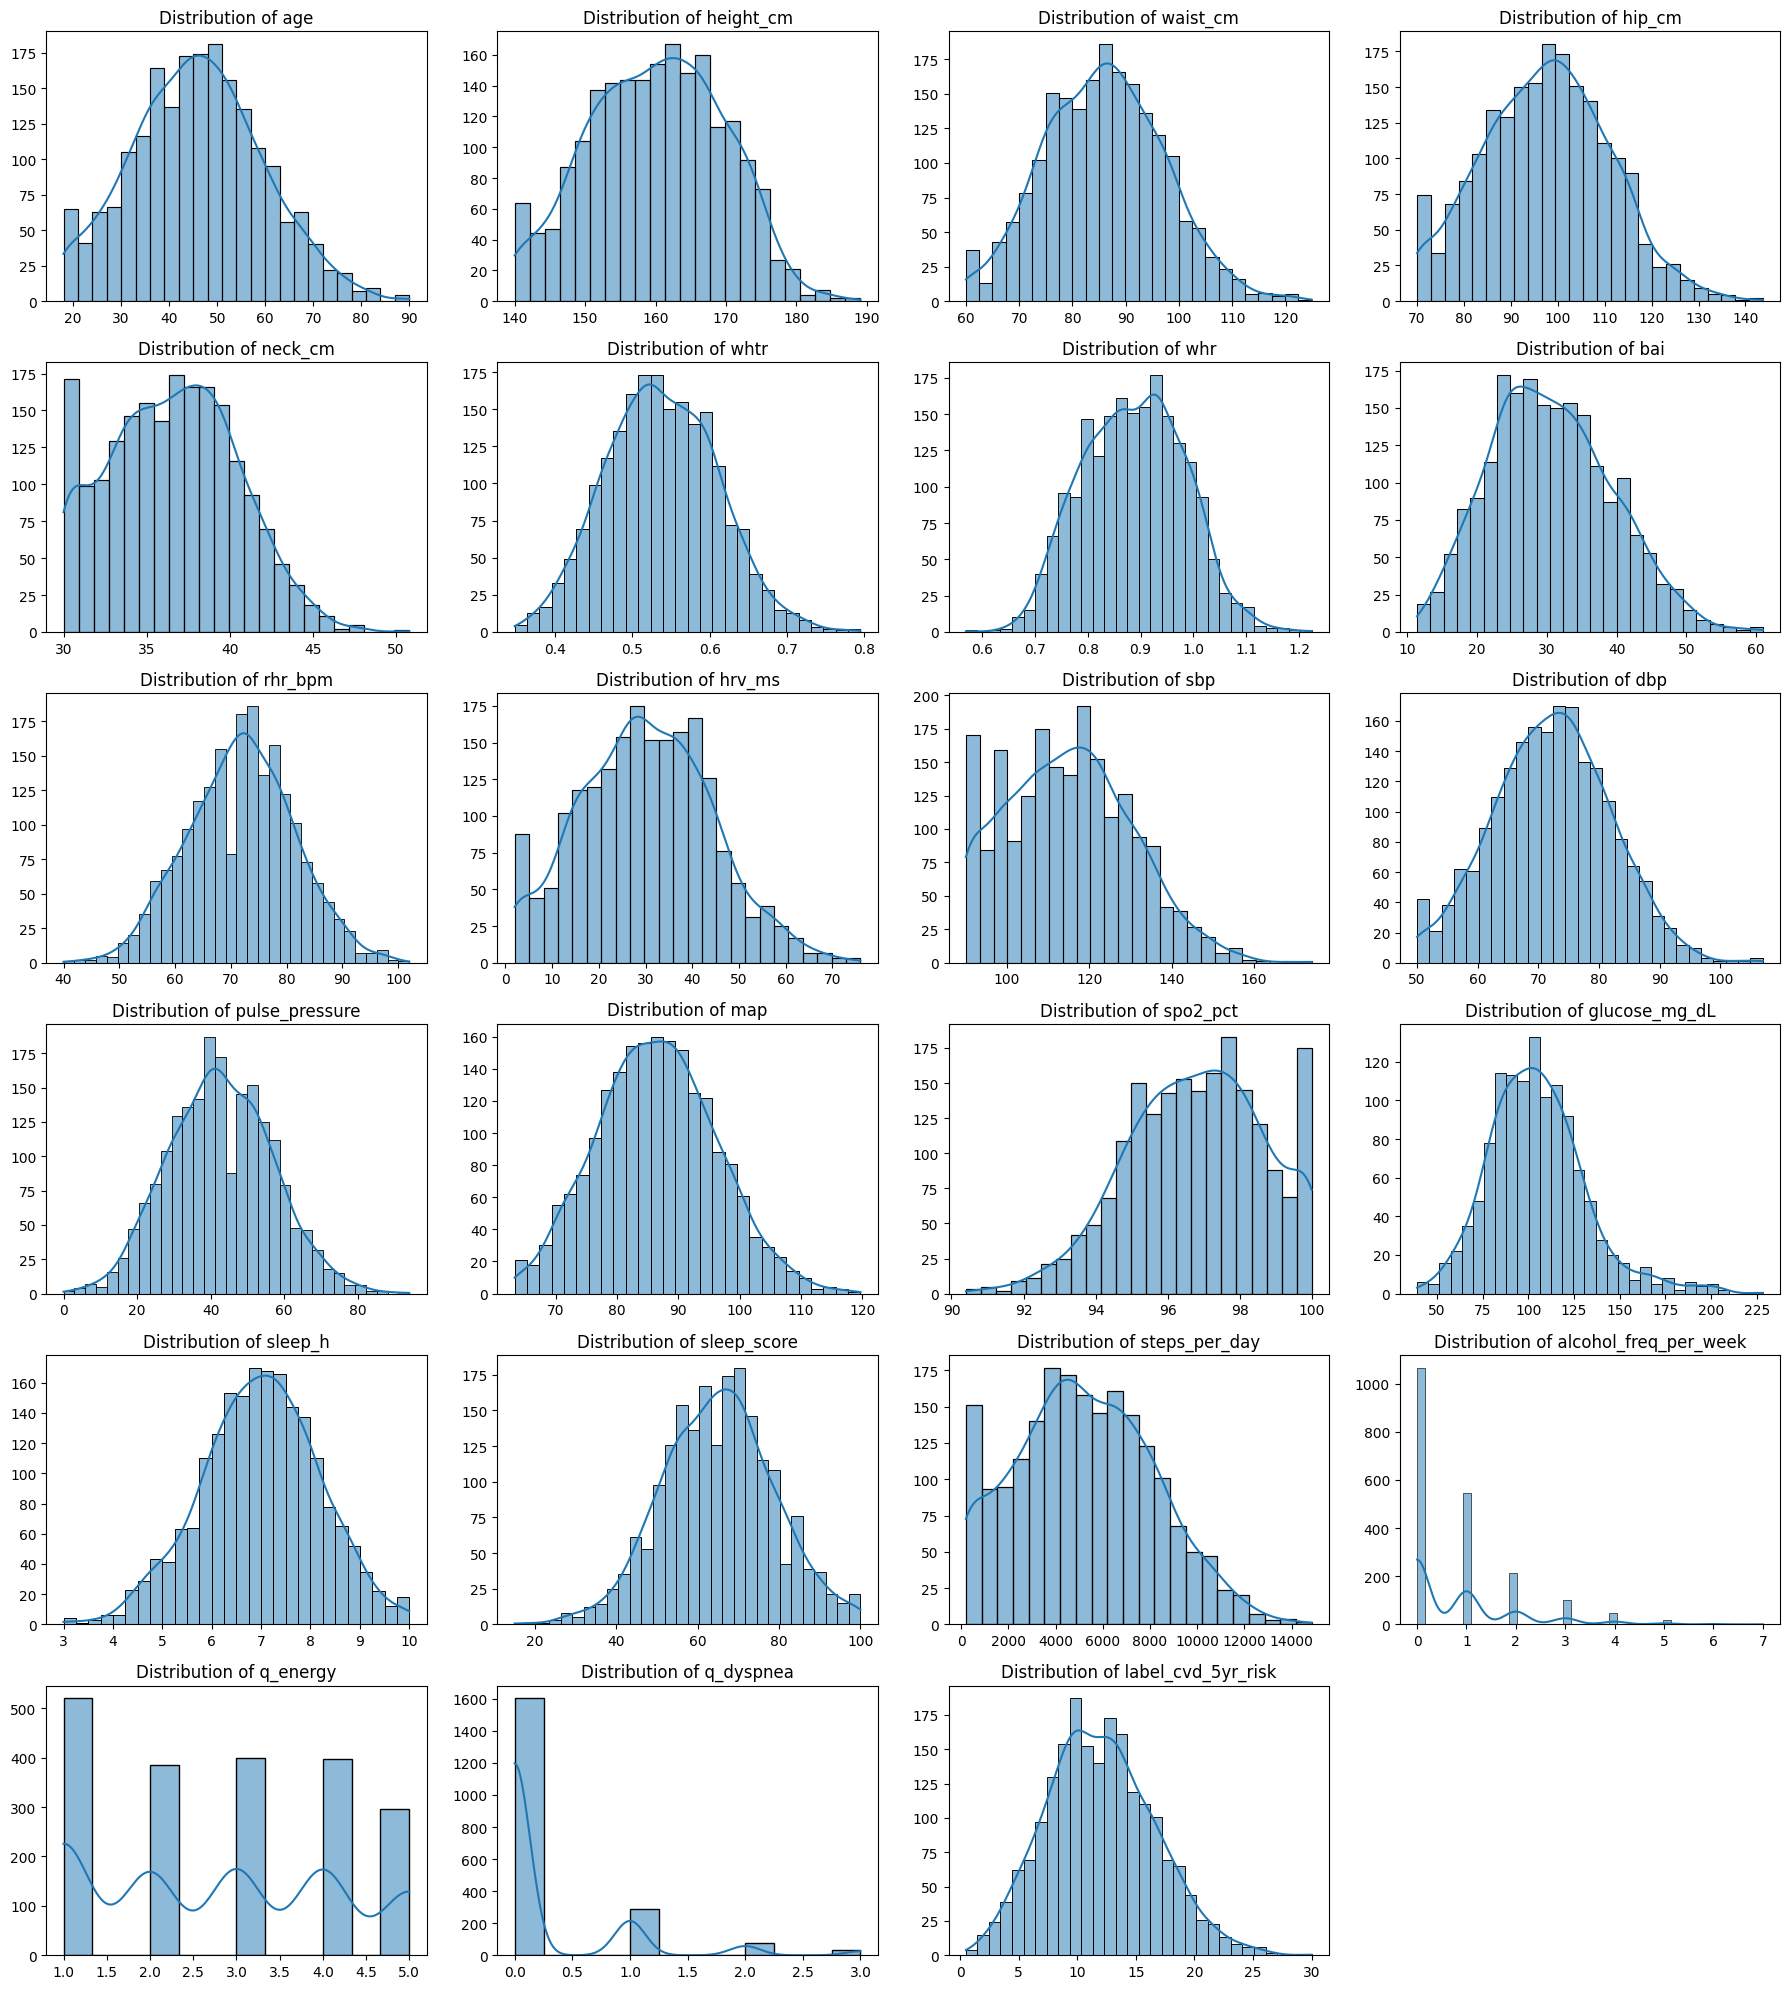

In [ ]:
numerical_cols = df.select_dtypes(include=np.number).columns.tolist()
# Exclude 'id' and 'glucose_missing' which are not truly numerical for distribution plots
# 'glucose_missing' is a binary indicator, better treated as categorical for count plots
# 'weight_kg' has only one unique value so it's not useful to plot its distribution
numerical_cols_to_plot = [col for col in numerical_cols if col not in ['id', 'glucose_missing', 'weight_kg']]

plt.figure(figsize=(18, 20))
for i, col in enumerate(numerical_cols_to_plot):
    plt.subplot(6, 4, i + 1)
    sns.histplot(df[col].dropna(), kde=True)
    plt.title(f'Distribution of {col}')
    plt.xlabel('')
    plt.ylabel('')
plt.tight_layout()
plt.show()

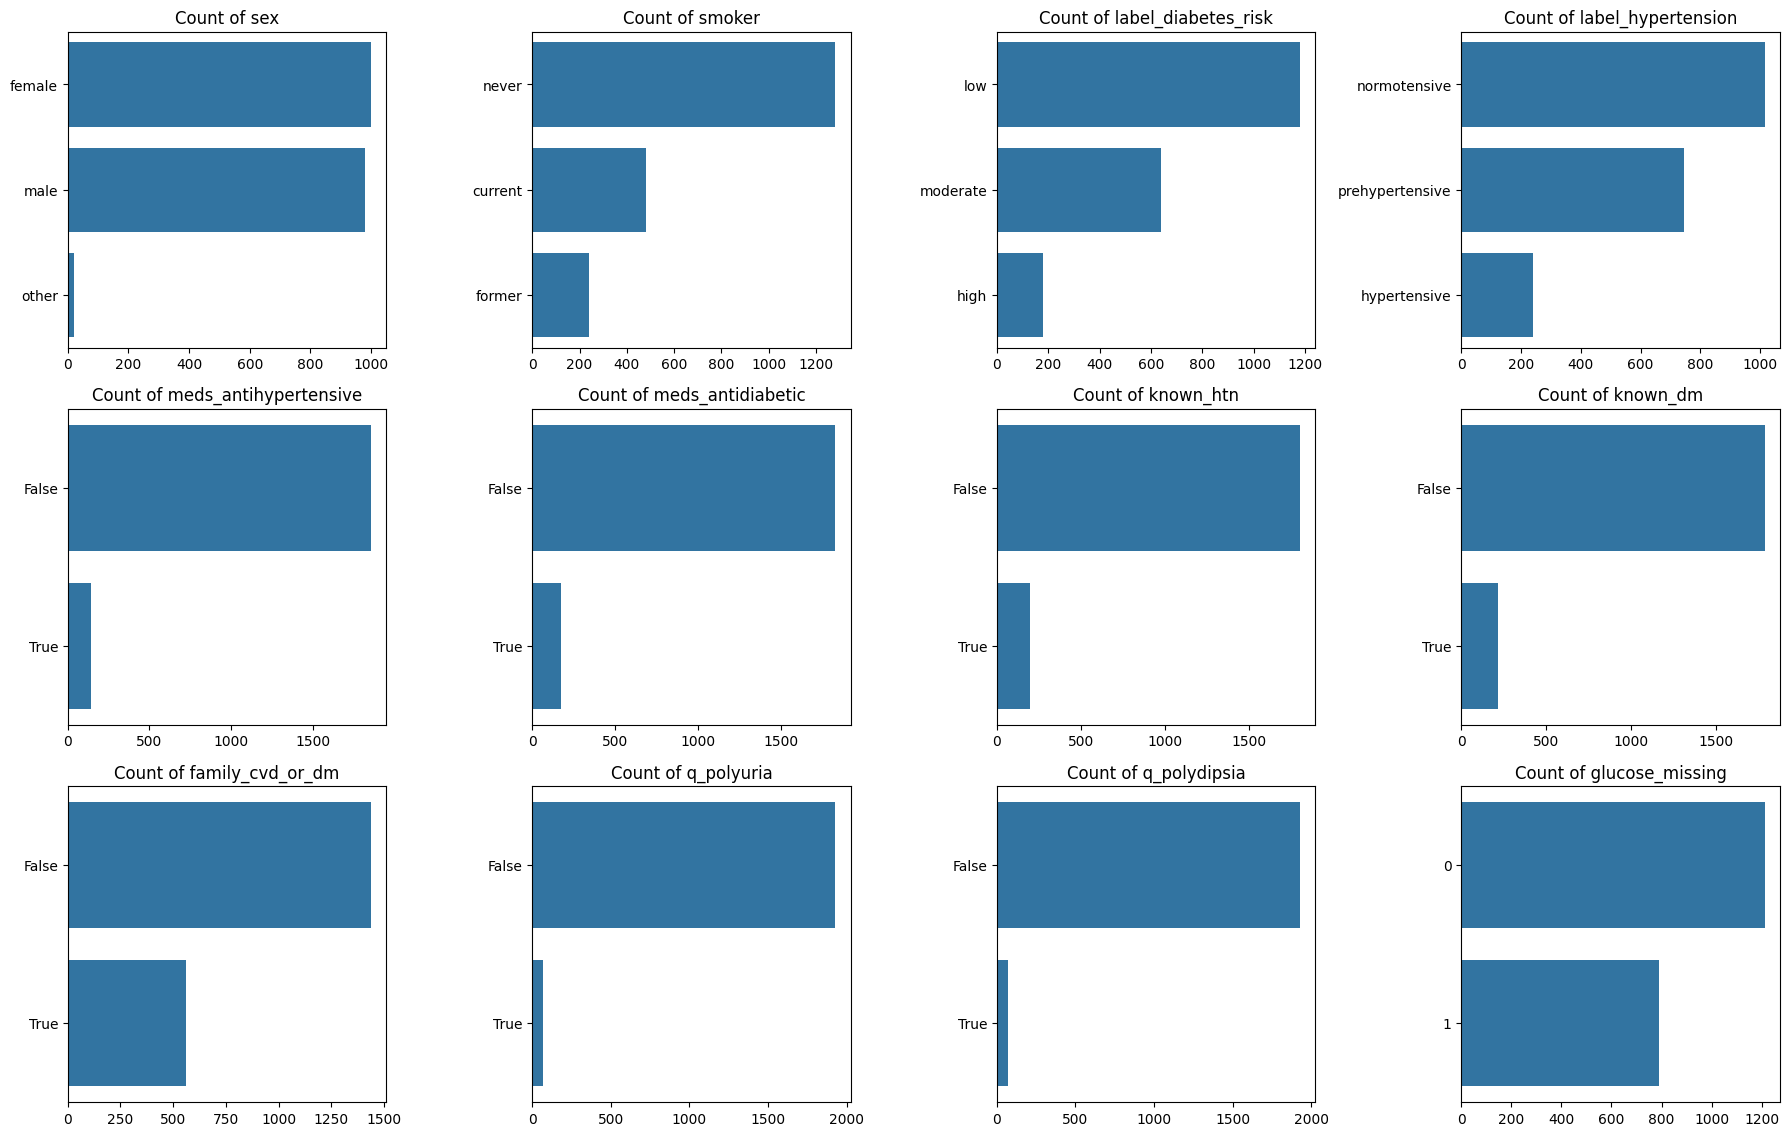

In [ ]:
categorical_cols = df.select_dtypes(include='object').columns.tolist()
bool_cols = df.select_dtypes(include='bool').columns.tolist()

# Combine categorical columns and boolean columns
categorical_features = categorical_cols + bool_cols + ['glucose_missing'] # Add glucose_missing as it's binary
# Exclude 'id' as it's a unique identifier
categorical_features = [col for col in categorical_features if col not in ['id']]

plt.figure(figsize=(18, 15))
for i, col in enumerate(categorical_features):
    plt.subplot(4, 4, i + 1)
    sns.countplot(y=df[col], order=df[col].value_counts().index)
    plt.title(f'Count of {col}')
    plt.xlabel('')
    plt.ylabel('')
plt.tight_layout()
plt.show()

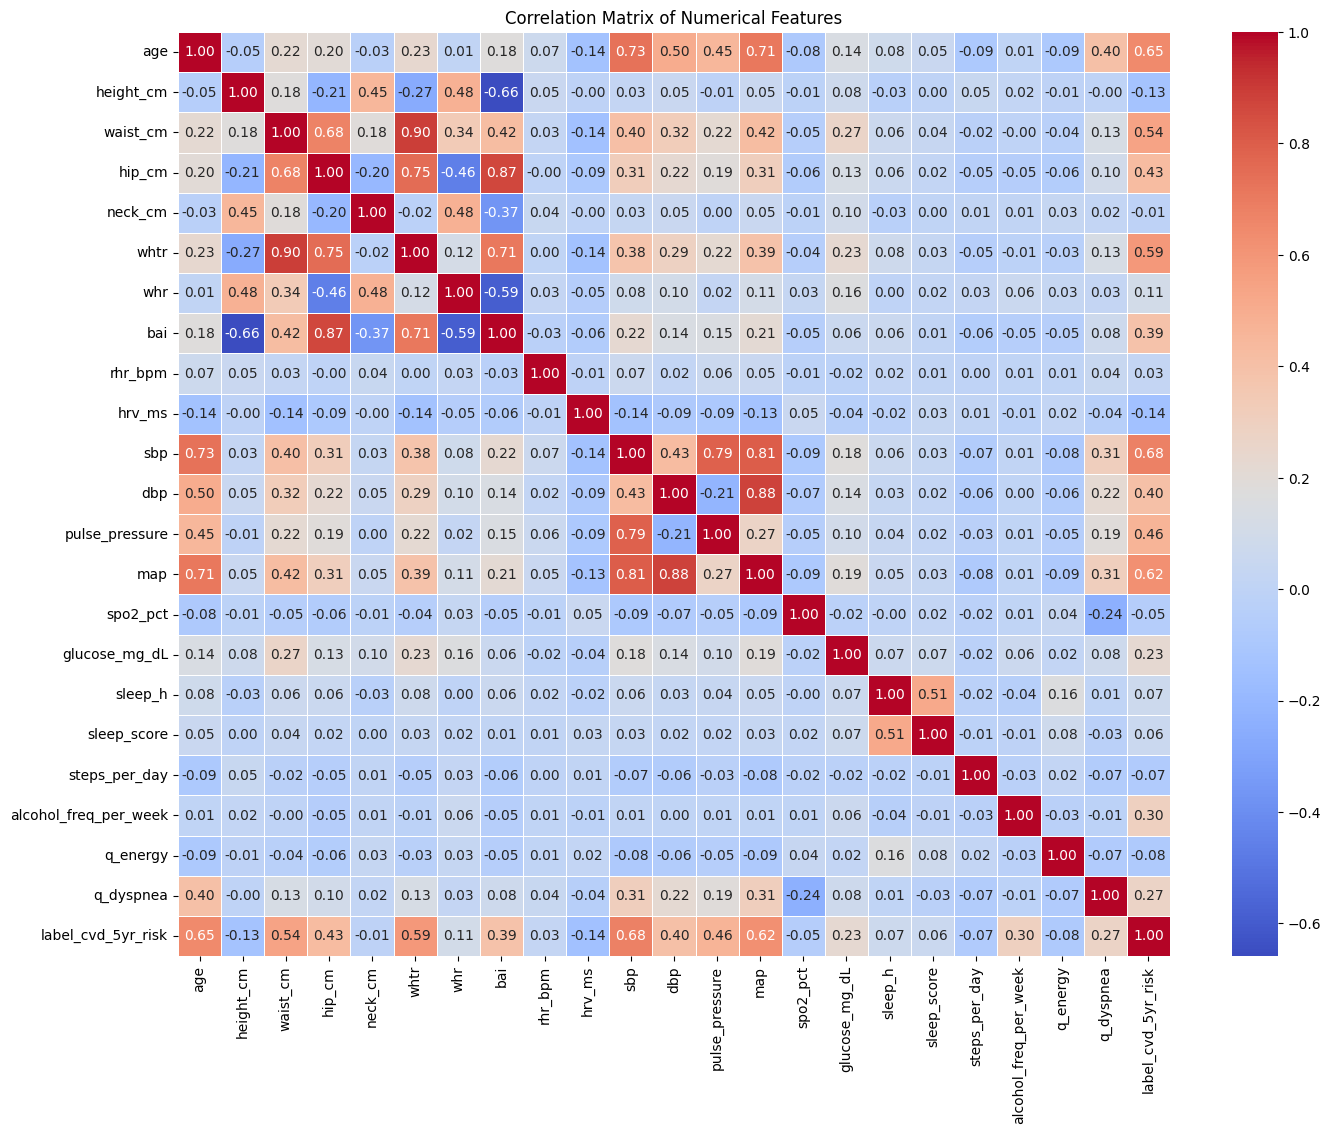

In [ ]:
plt.figure(figsize=(16, 12))
correlation_matrix = df[numerical_cols_to_plot].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Correlation Matrix of Numerical Features')
plt.show()

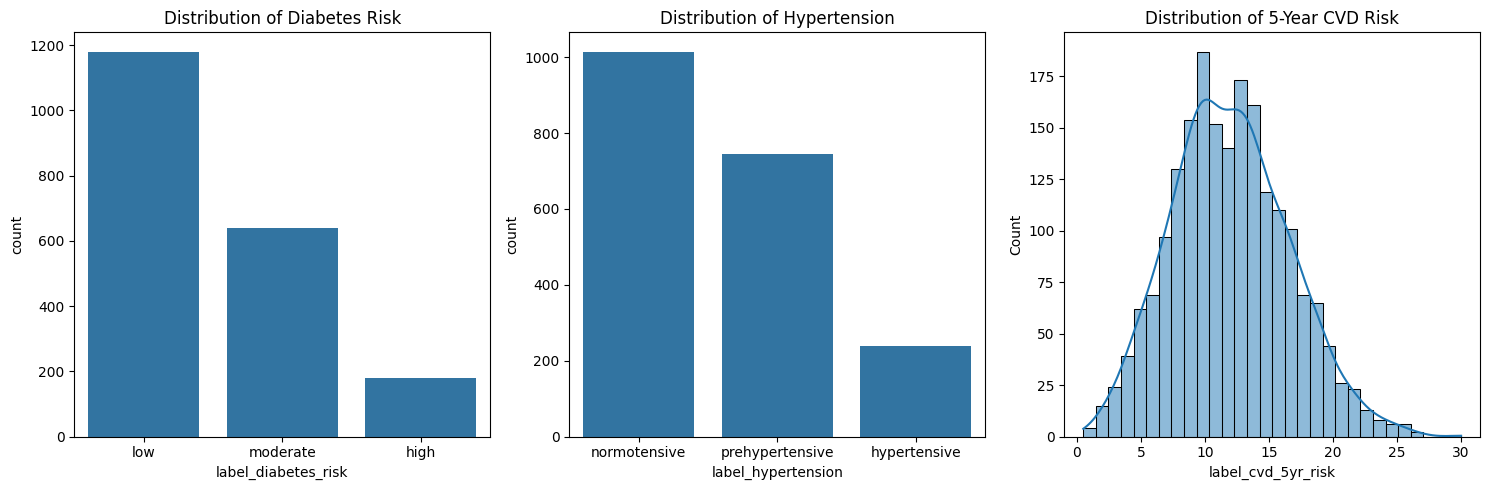

In [ ]:
target_vars = ['label_diabetes_risk', 'label_hypertension', 'label_cvd_5yr_risk']

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.countplot(x=df['label_diabetes_risk'], order=['low', 'moderate', 'high'])
plt.title('Distribution of Diabetes Risk')

plt.subplot(1, 3, 2)
sns.countplot(x=df['label_hypertension'], order=['normotensive', 'prehypertensive', 'hypertensive'])
plt.title('Distribution of Hypertension')

plt.subplot(1, 3, 3)
sns.histplot(df['label_cvd_5yr_risk'], kde=True)
plt.title('Distribution of 5-Year CVD Risk')

plt.tight_layout()
plt.show()

In [ ]:
target_variables = ['label_diabetes_risk', 'label_hypertension', 'label_cvd_5yr_risk']

features_to_drop = ['id', 'glucose_mg_dL', 'glucose_missing'] + target_variables

X = df.drop(columns=features_to_drop)
y = df[target_variables]

print("Shape of features (X):", X.shape)
print("Shape of targets (y):", y.shape)
print("First 5 rows of features (X):\n", X.head())
print("First 5 rows of targets (y):\n", y.head())

Shape of features (X): (2000, 31)
Shape of targets (y): (2000, 3)
First 5 rows of features (X):
    age     sex  height_cm  weight_kg  waist_cm  hip_cm  neck_cm   whtr    whr  \
0   52    male      174.5         40      84.4    82.9     42.3  0.484  1.018   
1   43    male      171.2         40      90.2   103.3     38.9  0.527  0.873   
2   54    male      183.1         40      92.8    87.4     39.9  0.507  1.062   
3   66    male      156.6         40      97.7   109.1     40.0  0.624  0.896   
4   42  female      161.9         40      83.4   102.8     31.7  0.515  0.811   

     bai  ...  alcohol_freq_per_week  meds_antihypertensive  \
0  17.96  ...                      0                  False   
1  28.12  ...                      1                  False   
2  17.28  ...                      0                  False   
3  37.67  ...                      2                  False   
4  31.90  ...                      2                   True   

   meds_antidiabetic  known_htn  know

In [ ]:
categorical_cols = X.select_dtypes(include=['object', 'bool']).columns

# Apply one-hot encoding to the categorical columns
X = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

print("First 5 rows of features (X) after one-hot encoding:\n", X.head())
print("\nNew shape of features (X):", X.shape)

First 5 rows of features (X) after one-hot encoding:
    age  height_cm  weight_kg  waist_cm  hip_cm  neck_cm   whtr    whr    bai  \
0   52      174.5         40      84.4    82.9     42.3  0.484  1.018  17.96   
1   43      171.2         40      90.2   103.3     38.9  0.527  0.873  28.12   
2   54      183.1         40      92.8    87.4     39.9  0.507  1.062  17.28   
3   66      156.6         40      97.7   109.1     40.0  0.624  0.896  37.67   
4   42      161.9         40      83.4   102.8     31.7  0.515  0.811  31.90   

   rhr_bpm  ...  sex_other  smoker_former  smoker_never  \
0       71  ...      False          False          True   
1       59  ...      False          False          True   
2       67  ...      False          False          True   
3       84  ...      False          False          True   
4       73  ...      False          False         False   

   meds_antihypertensive_True  meds_antidiabetic_True  known_htn_True  \
0                       False        

In [ ]:
numerical_cols_to_scale = X.select_dtypes(include=np.number).columns

# Exclude 'weight_kg' if it's still present and has only one unique value, or any other columns that should not be scaled
# In this case, after one-hot encoding, boolean columns are now numerical (0 or 1), they generally don't need scaling.
# Let's filter out columns that are essentially binary (0 or 1) after one-hot encoding, as well as the 'weight_kg' column which has a single value.

# Let's get the list of original numerical columns (excluding glucose_mg_dL, glucose_missing, id)
pure_numerical_cols_before_encoding = ['age', 'height_cm', 'weight_kg', 'waist_cm', 'hip_cm', 'neck_cm', 'whtr', 'whr', 'bai', 'rhr_bpm', 'hrv_ms', 'sbp', 'dbp', 'pulse_pressure', 'map', 'spo2_pct', 'sleep_h', 'sleep_score', 'steps_per_day', 'alcohol_freq_per_week', 'q_energy', 'q_dyspnea']


# Get numerical columns
all_numerical_cols_in_X = X.select_dtypes(include=[np.number]).columns.tolist()


# Get all numerical columns from X
all_current_numerical_cols = X.select_dtypes(include=np.number).columns

continuous_numerical_cols = [col for col in pure_numerical_cols_before_encoding if col in X.columns and col != 'weight_kg']


scaler = StandardScaler()

# Apply scaling to the identified continuous numerical columns
X[continuous_numerical_cols] = scaler.fit_transform(X[continuous_numerical_cols])

print("First 5 rows of features (X) after feature scaling:\n", X.head())
print("\nDescriptive statistics of scaled numerical features:\n", X[continuous_numerical_cols].describe().transpose())

First 5 rows of features (X) after feature scaling:
         age  height_cm  weight_kg  waist_cm    hip_cm   neck_cm      whtr  \
0  0.461158   1.516317         40 -0.137796 -1.092871  1.496726 -0.751916   
1 -0.203707   1.167708         40  0.379565  0.431482  0.609089 -0.150965   
2  0.608906   2.424812         40  0.611485 -0.756617  0.870159 -0.430477   
3  1.495394  -0.374622         40  1.048566  0.864876  0.896266  1.204670   
4 -0.277581   0.185264         40 -0.226997  0.394120 -1.270614 -0.318672   

        whr       bai   rhr_bpm  ...  sex_other  smoker_former  smoker_never  \
0  1.371456 -1.450103 -0.093080  ...      False          False          True   
1 -0.149645 -0.281215 -1.360919  ...      False          False          True   
2  1.833032 -1.528335 -0.515693  ...      False          False          True   
3  0.091633  0.817494  1.280411  ...      False          False          True   
4 -0.800047  0.153667  0.118226  ...      False          False         False   

   

### Checking Class Distribution of Target Variables

In [ ]:
print("Distribution of label_diabetes_risk:")
print(y['label_diabetes_risk'].value_counts(normalize=True))
print("\nDistribution of label_hypertension:")
print(y['label_hypertension'].value_counts(normalize=True))

Distribution of label_diabetes_risk:
label_diabetes_risk
low         0.59
moderate    0.32
high        0.09
Name: proportion, dtype: float64

Distribution of label_hypertension:
label_hypertension
normotensive       0.5075
prehypertensive    0.3725
hypertensive       0.1200
Name: proportion, dtype: float64


### Handling Class Imbalance with SMOTE



In [ ]:


from imblearn.over_sampling import SMOTE

# let's balance 'label_diabetes_risk'
# We need X and a single target variable for SMOTE

X_smote = X.copy()
y_diabetes_risk = y['label_diabetes_risk']

# Convert categorical target to numerical labels for SMOTE

class_mapping = {'low': 0, 'moderate': 1, 'high': 2}
y_diabetes_risk_encoded = y_diabetes_risk.map(class_mapping)

print("Original target distribution for label_diabetes_risk:")
print(y_diabetes_risk_encoded.value_counts())

# Apply SMOTE
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_smote, y_diabetes_risk_encoded)

print("\nResampled target distribution for label_diabetes_risk:")
print(y_res.value_counts())

print("\nShape of X before SMOTE:", X.shape)
print("Shape of X after SMOTE:", X_res.shape)

Original target distribution for label_diabetes_risk:
label_diabetes_risk
0    1180
1     640
2     180
Name: count, dtype: int64

Resampled target distribution for label_diabetes_risk:
label_diabetes_risk
0    1180
1    1180
2    1180
Name: count, dtype: int64

Shape of X before SMOTE: (2000, 33)
Shape of X after SMOTE: (3540, 33)


## Model Training and Evaluation


In [ ]:
# Split the SMOTE-resampled data into training and testing sets
# We use X_res and y_res from the previous SMOTE step
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.3, random_state=42, stratify=y_res)

print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

print("\nDistribution of y_train:")
print(y_train.value_counts(normalize=True))
print("\nDistribution of y_test:")
print(y_test.value_counts(normalize=True))

Shape of X_train: (2478, 33)
Shape of X_test: (1062, 33)
Shape of y_train: (2478,)
Shape of y_test: (1062,)

Distribution of y_train:
label_diabetes_risk
2    0.333333
0    0.333333
1    0.333333
Name: proportion, dtype: float64

Distribution of y_test:
label_diabetes_risk
0    0.333333
1    0.333333
2    0.333333
Name: proportion, dtype: float64


### Train a LightGBM Classifier


In [ ]:
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Initialize and train the LightGBM classifier
# We set objective to 'multiclass' as we have 3 classes for diabetes risk
lgbm_model = LGBMClassifier(objective='multiclass', num_class=3, random_state=42)
lgbm_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = lgbm_model.predict(X_test)
y_pred_proba = lgbm_model.predict_proba(X_test)

print("Model training complete.")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001126 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5359
[LightGBM] [Info] Number of data points in the train set: 2478, number of used features: 32
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
Model training complete.


Classification Report:
              precision    recall  f1-score   support

         low       0.76      0.71      0.74       354
    moderate       0.71      0.72      0.71       354
        high       0.91      0.95      0.93       354

    accuracy                           0.80      1062
   macro avg       0.79      0.80      0.79      1062
weighted avg       0.79      0.80      0.79      1062


Accuracy: 0.7957


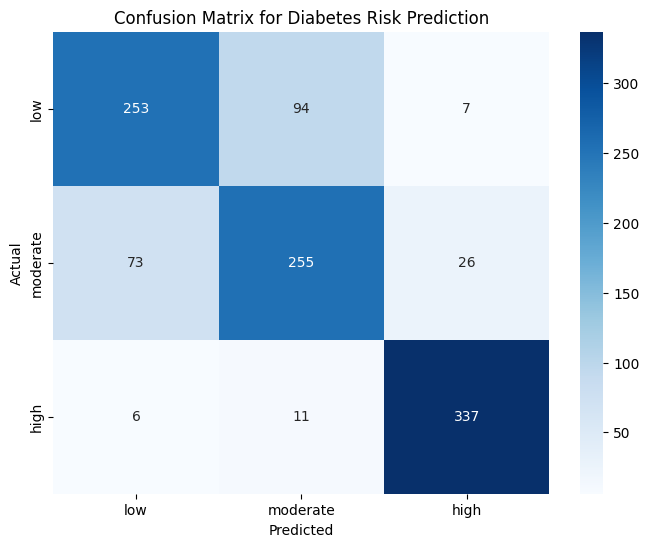

In [ ]:
# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['low', 'moderate', 'high']))

# Print accuracy score
accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy: {accuracy:.4f}")

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues',
            xticklabels=['low', 'moderate', 'high'], yticklabels=['low', 'moderate', 'high'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Diabetes Risk Prediction')
plt.show()

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform

# Define the parameter distribution for RandomizedSearchCV
param_dist = {
    'num_leaves': sp_randint(20, 60),  # Max number of leaves in one tree
    'max_depth': sp_randint(5, 15),    # Max tree depth
    'learning_rate': sp_uniform(0.01, 0.1), # Step size shrinkage
    'n_estimators': sp_randint(100, 500), # Number of boosting rounds
    'subsample': sp_uniform(0.7, 0.3),  # Subsample ratio of the training instance
    'colsample_bytree': sp_uniform(0.7, 0.3), # Subsample ratio of columns when constructing each tree
    'reg_alpha': sp_uniform(0.01, 0.5), # L1 regularization term on weights
    'reg_lambda': sp_uniform(0.01, 0.5) # L2 regularization term on weights
}

# Initialize LGBMClassifier with multiclass objective
lgbm = LGBMClassifier(objective='multiclass', num_class=3, random_state=42)

# Initialize RandomizedSearchCV
# n_iter: Number of parameter settings that are sampled. Reduce if computation is too long.
# cv: Number of folds for cross-validation
random_search = RandomizedSearchCV(lgbm, param_distributions=param_dist, n_iter=50, cv=5,
                                   scoring='f1_weighted', random_state=42, n_jobs=-1, verbose=1)

# Fit RandomizedSearchCV to the training data
random_search.fit(X_train, y_train)

print("Best parameters found by RandomizedSearchCV:", random_search.best_params_)
print("Best F1-weighted score:", random_search.best_score_)

# Get the best estimator
best_lgbm_model = random_search.best_estimator_
print("\nModel tuning complete. Retraining with best parameters and re-evaluating...")

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000673 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5359
[LightGBM] [Info] Number of data points in the train set: 2478, number of used features: 32
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

Classification Report (Tuned Model):
              precision    recall  f1-score   support

         low       0.78      0.73      0.75       354
    moderate       0.72      0.74      0.73       354
        high       0.91      0.94      0.93       354

    accuracy                           0.80      1062
   macro avg       0.80      0.80      0.80      1062
weighted avg       0.80      0.80      0.80      1062


Accuracy (Tuned Model): 0.8032


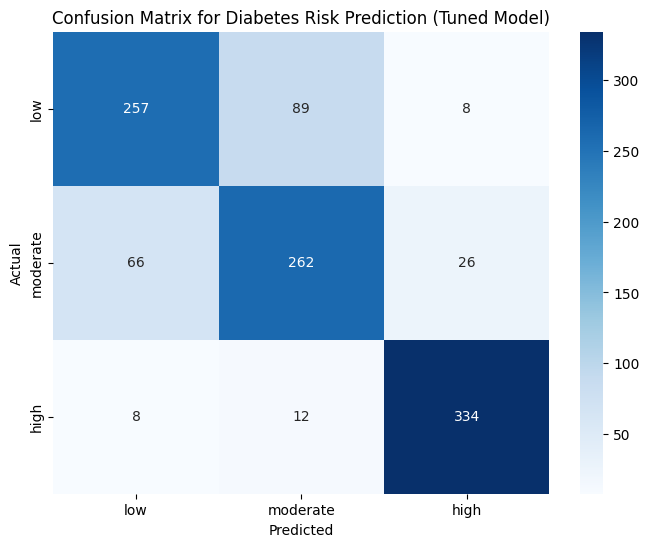

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Make predictions with the best model
y_pred_tuned = best_lgbm_model.predict(X_test)
y_pred_proba_tuned = best_lgbm_model.predict_proba(X_test)

# Print classification report for the tuned model
print("Classification Report (Tuned Model):")
print(classification_report(y_test, y_pred_tuned, target_names=['low', 'moderate', 'high']))

# Print accuracy score for the tuned model
accuracy_tuned = accuracy_score(y_test, y_pred_tuned)
print(f"\nAccuracy (Tuned Model): {accuracy_tuned:.4f}")

# Plot confusion matrix for the tuned model
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred_tuned), annot=True, fmt='d', cmap='Blues',
            xticklabels=['low', 'moderate', 'high'], yticklabels=['low', 'moderate', 'high'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Diabetes Risk Prediction (Tuned Model)')
plt.show()

## Heart Disease Prediction (Regression Model)

We will now train a regression model to predict `label_cvd_5yr_risk`.

In [ ]:
# Prepare the target variable for CVD 5-year risk
y_cvd_risk = y['label_cvd_5yr_risk']

# Split the preprocessed features (X) and the new target into training and testing sets
# Note: We use the original X (after encoding and scaling) and the CVD risk target.
# No SMOTE is applied for regression problems in this context.
from sklearn.model_selection import train_test_split
X_train_cvd, X_test_cvd, y_train_cvd, y_test_cvd = train_test_split(X, y_cvd_risk, test_size=0.3, random_state=42)

print("Shape of X_train_cvd:", X_train_cvd.shape)
print("Shape of X_test_cvd:", X_test_cvd.shape)
print("Shape of y_train_cvd:", y_train_cvd.shape)
print("Shape of y_test_cvd:", y_test_cvd.shape)

Shape of X_train_cvd: (1400, 33)
Shape of X_test_cvd: (600, 33)
Shape of y_train_cvd: (1400,)
Shape of y_test_cvd: (600,)


### Train a LightGBM Regressor

We will use a `LGBMRegressor` to predict the continuous `label_cvd_5yr_risk`.

In [ ]:
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


lgbm_regressor = LGBMRegressor(random_state=42)
lgbm_regressor.fit(X_train_cvd, y_train_cvd)


y_pred_cvd = lgbm_regressor.predict(X_test_cvd)

print("Regression model training complete.")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003106 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2864
[LightGBM] [Info] Number of data points in the train set: 1400, number of used features: 31
[LightGBM] [Info] Start training from score 11.863214
Regression model training complete.


### Evaluate the Regression Model

We will evaluate the regression model's performance using standard regression metrics.

Mean Absolute Error (MAE): 0.4019
Mean Squared Error (MSE): 0.3302
Root Mean Squared Error (RMSE): 0.5746
R-squared (R2): 0.9850


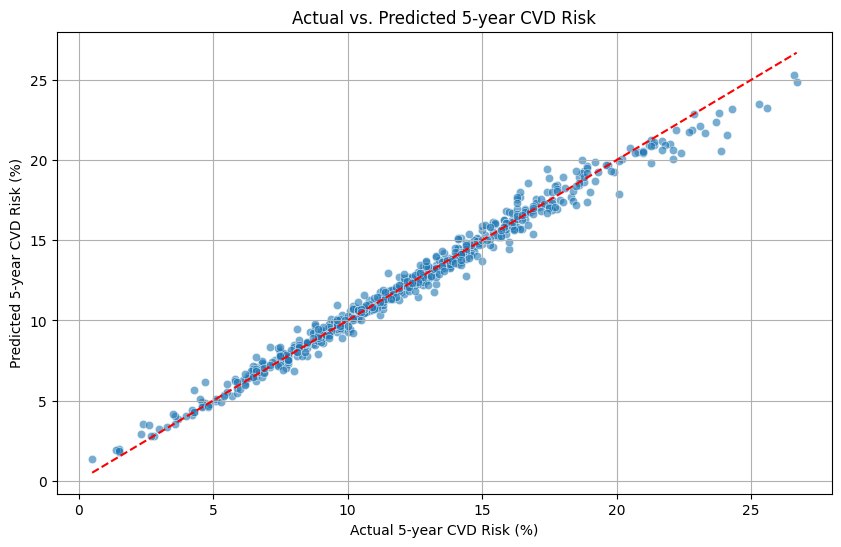

In [ ]:
# Calculate evaluation metrics
mae = mean_absolute_error(y_test_cvd, y_pred_cvd)
mse = mean_squared_error(y_test_cvd, y_pred_cvd)
rmse = np.sqrt(mse) # Root Mean Squared Error
r2 = r2_score(y_test_cvd, y_pred_cvd)

print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared (R2): {r2:.4f}")

# Plot actual vs. predicted values
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test_cvd, y=y_pred_cvd, alpha=0.6)
plt.plot([y_test_cvd.min(), y_test_cvd.max()], [y_test_cvd.min(), y_test_cvd.max()], 'r--')
plt.xlabel('Actual 5-year CVD Risk (%)')
plt.ylabel('Predicted 5-year CVD Risk (%)')
plt.title('Actual vs. Predicted 5-year CVD Risk')
plt.grid(True)
plt.show()

### Train and Evaluate XGBoost Classifier


Training XGBoost Classifier...


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [04:29:23] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Model training complete. Evaluating performance...

Classification Report (XGBoost Model):
              precision    recall  f1-score   support

         low       0.76      0.75      0.76       354
    moderate       0.72      0.71      0.72       354
        high       0.91      0.94      0.92       354

    accuracy                           0.80      1062
   macro avg       0.80      0.80      0.80      1062
weighted avg       0.80      0.80      0.80      1062


Accuracy (XGBoost Model): 0.7994


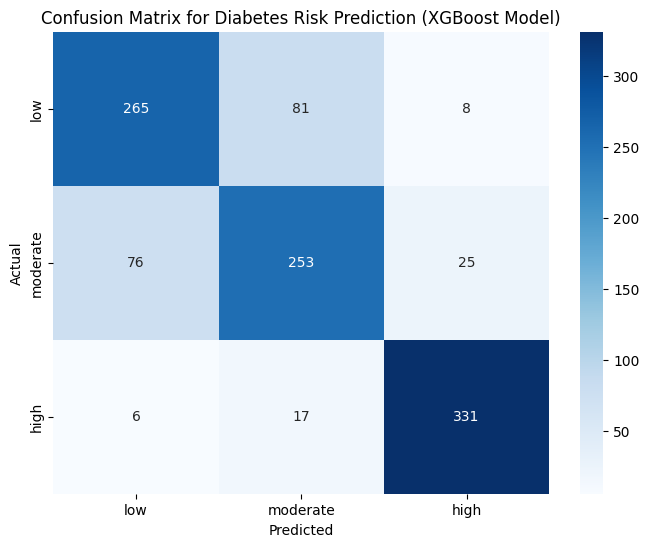

In [ ]:


from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

print("Training XGBoost Classifier...")


xgb_model = XGBClassifier(objective='multi:softmax', num_class=3, eval_metric='mlogloss', use_label_encoder=False, random_state=42)
xgb_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_xgb = xgb_model.predict(X_test)

print("XGBoost Model training complete. Evaluating performance...")

# Print classification report
print("\nClassification Report (XGBoost Model):")
print(classification_report(y_test, y_pred_xgb, target_names=['low', 'moderate', 'high']))

# Print accuracy score
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print(f"\nAccuracy (XGBoost Model): {accuracy_xgb:.4f}")

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred_xgb), annot=True, fmt='d', cmap='Blues',
            xticklabels=['low', 'moderate', 'high'], yticklabels=['low', 'moderate', 'high'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Diabetes Risk Prediction (XGBoost Model)')
plt.show()



### Train and Evaluate CatBoost Classifier



In [ ]:
#pip install catboost

Training CatBoost Classifier...
CatBoost Model training complete. Evaluating performance...

Classification Report (CatBoost Model):
              precision    recall  f1-score   support

         low       0.74      0.69      0.72       354
    moderate       0.64      0.64      0.64       354
        high       0.85      0.90      0.88       354

    accuracy                           0.74      1062
   macro avg       0.74      0.74      0.74      1062
weighted avg       0.74      0.74      0.74      1062


Accuracy (CatBoost Model): 0.7448


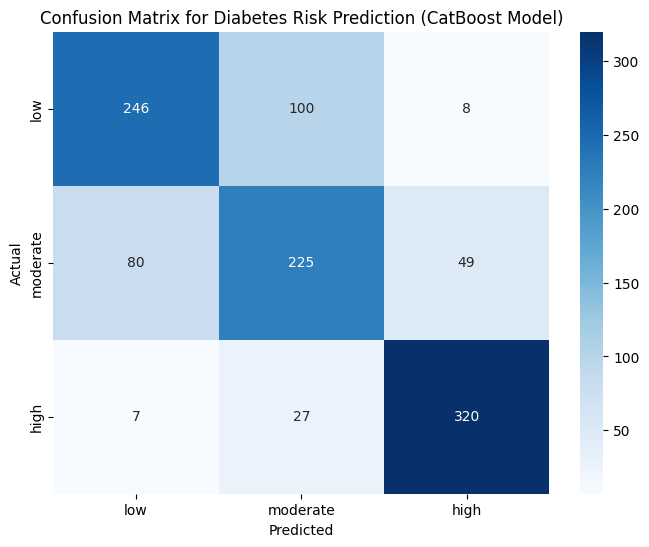

In [ ]:

from catboost import CatBoostClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

print("Training CatBoost Classifier...")

# Initialize and train the CatBoost classifier
# CatBoost handles categorical features automatically if specified, but our features are already one-hot encoded.
# Loss function 'MultiClass' for multi-class classification
cat_model = CatBoostClassifier(iterations=100,  # Number of boosting rounds
                             learning_rate=0.1,
                             depth=6,
                             loss_function='MultiClass',
                             random_seed=42,
                             verbose=0) # Set verbose to 0 to suppress training output

cat_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_cat = cat_model.predict(X_test)

print("CatBoost Model training complete. Evaluating performance...")

# CatBoost predicts labels as a 2D array if the output is MultiClass, so flatten it
y_pred_cat_flat = y_pred_cat.flatten()

# Print classification report
print("\nClassification Report (CatBoost Model):")
print(classification_report(y_test, y_pred_cat_flat, target_names=['low', 'moderate', 'high']))

# Print accuracy score
accuracy_cat = accuracy_score(y_test, y_pred_cat_flat)
print(f"\nAccuracy (CatBoost Model): {accuracy_cat:.4f}")

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred_cat_flat), annot=True, fmt='d', cmap='Blues',
            xticklabels=['low', 'moderate', 'high'], yticklabels=['low', 'moderate', 'high'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Diabetes Risk Prediction (CatBoost Model)')
plt.show()

### Hyperparameter Tuning for XGBoost Classifier

Fitting 5 folds for each of 50 candidates, totalling 250 fits


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [04:40:54] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best parameters found for XGBoost by RandomizedSearchCV: {'colsample_bytree': np.float64(0.6661067756252009), 'gamma': np.float64(0.007818203370596966), 'lambda': np.float64(1.8468029614127393), 'learning_rate': np.float64(0.08897630363511394), 'max_depth': 9, 'n_estimators': 238, 'subsample': np.float64(0.679536961635522)}
Best F1-weighted score for XGBoost: 0.8311604490898794

XGBoost model tuning complete. Retraining with best parameters and re-evaluating...

Classification Report (Tuned XGBoost Model):
              precision    recall  f1-score   support

         low       0.79      0.72      0.75       354
    moderate       0.72      0.74      0.73       354
        high       0.90      0.95      0.93       354

    accuracy                           0.80      1062
   macro avg       0.80      0.80      0.80      1062
weighted avg       0.80      0.80      0.80      1062


Accuracy (Tuned XGBoost Model): 0.8041


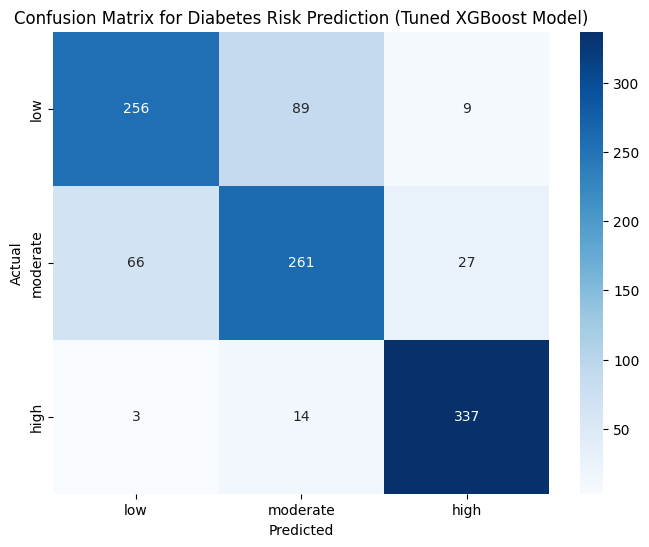

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Define parameter distribution for XGBoost
param_dist_xgb = {
    'n_estimators': sp_randint(100, 500),
    'learning_rate': sp_uniform(0.01, 0.2),
    'max_depth': sp_randint(3, 10),
    'subsample': sp_uniform(0.6, 0.4),
    'colsample_bytree': sp_uniform(0.6, 0.4),
    'gamma': sp_uniform(0, 0.5), # Minimum loss reduction required to make a further partition on a leaf node
    'lambda': sp_uniform(1, 2) # L2 regularization term on weights
}

# Initialize XGBoost Classifier
xgb = XGBClassifier(objective='multi:softmax', num_class=3, eval_metric='mlogloss', use_label_encoder=False, random_state=42)

# Initialize RandomizedSearchCV for XGBoost
random_search_xgb = RandomizedSearchCV(xgb, param_distributions=param_dist_xgb, n_iter=50, cv=5,
                                     scoring='f1_weighted', random_state=42, n_jobs=-1, verbose=1)

# Fit RandomizedSearchCV to the training data
random_search_xgb.fit(X_train, y_train)

print("Best parameters found for XGBoost by RandomizedSearchCV:", random_search_xgb.best_params_)
print("Best F1-weighted score for XGBoost:", random_search_xgb.best_score_)

# Get the best estimator for XGBoost
best_xgb_model = random_search_xgb.best_estimator_
print("\nXGBoost model tuning complete. Retraining with best parameters and re-evaluating...")

# Make predictions with the best XGBoost model
y_pred_xgb_tuned = best_xgb_model.predict(X_test)

# Print classification report for the tuned XGBoost model
print("\nClassification Report (Tuned XGBoost Model):")
print(classification_report(y_test, y_pred_xgb_tuned, target_names=['low', 'moderate', 'high']))

# Print accuracy score for the tuned XGBoost model
accuracy_xgb_tuned = accuracy_score(y_test, y_pred_xgb_tuned)
print(f"\nAccuracy (Tuned XGBoost Model): {accuracy_xgb_tuned:.4f}")

# Plot confusion matrix for the tuned XGBoost model
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred_xgb_tuned), annot=True, fmt='d', cmap='Blues',
            xticklabels=['low', 'moderate', 'high'], yticklabels=['low', 'moderate', 'high'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Diabetes Risk Prediction (Tuned XGBoost Model)')
plt.show()